In [ ]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import xgboost as xgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# XAI Libraries
import lime
from lime import lime_tabular
import shap

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

import pickle
from datetime import datetime

In [2]:
# Configuration - MODIFY THESE PATHS AS NEEDED
JSON_FILES_DIR = r"D:\B.Tech\Hackathons\CinehackAI\Harmful Data\img_txt"
OUTPUT_DIR = "models_improved"
BERT_MODEL = "bert-base-uncased"
BATCH_SIZE = 8
MAX_LENGTH = 96
RANDOM_SEED = 42
SAFE_SPEECH_RATIO = 1.5

# Overfitting prevention parameters
CV_FOLDS = 10
EARLY_STOPPING_ROUNDS = 25
VALIDATION_SPLIT = 0.25
TEST_SPLIT = 0.15
FEATURE_SELECTION_K = 400

# Create output directory
Path(OUTPUT_DIR).mkdir(exist_ok=True)

# Set random seeds for reproducibility
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

print(f"Configuration loaded. Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Data directory: {JSON_FILES_DIR}")

Configuration loaded. Using device: cuda
Output directory: models_improved
Data directory: D:\B.Tech\Hackathons\CinehackAI\Harmful Data\img_txt


In [3]:
def inspect_json_structure(file_path, max_depth=3):
    """Detailed inspection of JSON file structure"""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except Exception as e:
        print(f"Error loading file: {e}")
        return
    
    def inspect_obj(obj, depth=0, path="root"):
        if depth > max_depth:
            return
        
        indent = "  " * depth
        
        if isinstance(obj, dict):
            print(f"{indent}{path} [dict] with {len(obj)} keys")
            for key, value in list(obj.items())[:5]:  # Show first 5 keys
                print(f"{indent}  - '{key}': {type(value).__name__}", end="")
                if isinstance(value, str):
                    preview = value[:50].replace('\n', ' ')
                    print(f" = '{preview}...'")
                elif isinstance(value, (list, dict)):
                    print(f" (len={len(value)})")
                else:
                    print()
                
                if depth < max_depth - 1:
                    inspect_obj(value, depth + 1, f"{path}.{key}")
        
        elif isinstance(obj, list):
            print(f"{indent}{path} [list] with {len(obj)} items")
            if len(obj) > 0:
                print(f"{indent}  First item type: {type(obj[0]).__name__}")
                if depth < max_depth - 1:
                    inspect_obj(obj[0], depth + 1, f"{path}[0]")
    
    inspect_obj(data)

def extract_text_from_json(obj, texts=None):
    """Recursively extract all text fields from JSON"""
    if texts is None:
        texts = []
    
    if isinstance(obj, dict):
        # Common text field names - INCLUDING img_text for your dataset!
        for key in ['img_text', 'text', 'content', 'message', 'comment', 'post', 'tweet', 
                    'description', 'body', 'title', 'caption', 'review', 'label_text']:
            if key in obj:
                value = obj[key]
                if isinstance(value, str) and len(value.strip()) > 0:
                    texts.append(value.strip())
        
        # Recursively search nested dicts
        for value in obj.values():
            if isinstance(value, (dict, list)):
                extract_text_from_json(value, texts)
    
    elif isinstance(obj, list):
        for item in obj:
            if isinstance(item, (dict, list)):
                extract_text_from_json(item, texts)
    
    return texts

def load_json_files(directory):
    """Load all JSON files from directory"""
    json_files = list(Path(directory).glob("*.json"))
    all_texts = []
    failed_files = []
    
    if len(json_files) == 0:
        raise ValueError(f"No JSON files found in {directory}")
    
    print(f"Found {len(json_files)} JSON files")
    
    # Detailed inspection of first 3 files
    print("\n" + "="*60)
    print("INSPECTING FIRST 3 FILES FOR STRUCTURE")
    print("="*60)
    for i, file_path in enumerate(json_files[:3]):
        print(f"\n[File {i+1}] {file_path.name}")
        print("-" * 60)
        inspect_json_structure(file_path)
    
    print("\n" + "="*60)
    user_input = input("Press ENTER to continue loading all files, or type 'stop' to exit: ")
    if user_input.lower() == 'stop':
        raise KeyboardInterrupt("User stopped execution")
    
    print("\nLoading all files...")
    for file_path in tqdm(json_files, desc="Loading JSON files"):
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                extracted = extract_text_from_json(data)
                all_texts.extend(extracted)
        except Exception as e:
            failed_files.append((file_path.name, str(e)))
    
    if failed_files:
        print(f"\nWarning: Failed to load {len(failed_files)} files")
        if len(failed_files) <= 10:
            for fname, error in failed_files:
                print(f"  - {fname}: {error}")
        else:
            print("First 10 failures:")
            for fname, error in failed_files[:10]:
                print(f"  - {fname}: {error}")
    
    return all_texts

In [4]:
def preprocess_text(text):
    """Enhanced text preprocessing"""
    if not isinstance(text, str):
        return ""
    
    # Lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove mentions and hashtags (but keep the text after them)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    
    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^a-zA-Z0-9\s\.,!?;:\'-]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def augment_text(text, num_augmentations=2):
    """Simple text augmentation techniques"""
    augmented_texts = [text]  # Original text
    
    # Simple augmentation by word shuffling (maintaining meaning)
    words = text.split()
    if len(words) > 3:
        for _ in range(min(num_augmentations, 2)):
            # Shuffle only middle words to preserve sentence structure
            if len(words) > 4:
                middle_words = words[1:-1]
                np.random.shuffle(middle_words)
                augmented_text = words[0] + ' ' + ' '.join(middle_words) + ' ' + words[-1]
                augmented_texts.append(augmented_text)
    
    return augmented_texts

In [5]:
# Enhanced safe speech generation with better diversity
def generate_safe_speech(harmful_texts, ratio=1.0):
    """Generate safe speech data with better diversity"""
    
    # Enhanced templates for safe speech
    safe_templates = [
        # Positive statements
        "I really enjoyed {topic} today, it was wonderful",
        "Thank you for sharing your thoughts on {topic}",
        "I appreciate the discussion about {topic}",
        "Learning about {topic} has been very helpful",
        "The {topic} session was informative and well-organized",
        "Great insights on {topic}, very valuable",
        "I found the {topic} content quite engaging",
        
        # Neutral statements
        "I'm interested in learning more about {topic}",
        "Can you provide information on {topic}?",
        "What's your opinion on {topic}?",
        "I've been thinking about {topic} lately",
        "The article about {topic} was interesting",
        "Could you elaborate on the {topic} aspect?",
        "The {topic} discussion raises good points",
        
        # Encouraging statements
        "Great work on the {topic} project",
        "I'm happy to help with {topic}",
        "Let's collaborate on {topic}",
        "Your perspective on {topic} is valuable",
        "I respect your view on {topic}",
        "Excellent presentation on {topic}",
        "The {topic} approach seems promising",
        
        # General conversation
        "Have a great day everyone",
        "Looking forward to our next meeting",
        "Thanks for your time and consideration",
        "I hope you're doing well",
        "Best wishes for your project",
        "That's a good point to consider",
        "I understand what you mean",
        "Let me think about that",
        "That makes sense to me",
        "I see your perspective",
        "This is a constructive discussion",
        "I appreciate everyone's input",
        "Thank you for the clarification",
        "This has been very educational",
        "I'm glad we could discuss this"
    ]
    
    topics = [
        "technology", "education", "sports", "music", "art", "science",
        "literature", "food", "travel", "health", "fitness", "nature",
        "history", "culture", "business", "environment", "community",
        "family", "friends", "hobbies", "movies", "books", "photography",
        "gaming", "cooking", "design", "architecture", "astronomy",
        "research", "innovation", "collaboration", "learning", "creativity",
        "development", "progress", "improvement", "achievement", "success"
    ]
    
    num_safe = int(len(harmful_texts) * ratio)
    safe_texts = []
    
    print(f"Generating {num_safe} safe speech examples...")
    
    for _ in range(num_safe):
        template = np.random.choice(safe_templates)
        if '{topic}' in template:
            topic = np.random.choice(topics)
            text = template.format(topic=topic)
        else:
            text = template
        
        # Add variation
        if np.random.random() > 0.5:
            text = text.capitalize()
        if np.random.random() > 0.7:
            text += "."
        
        safe_texts.append(text)
    
    return safe_texts

In [6]:
def apply_feature_selection(X_train, y_train, X_val, X_test, k=400):
    """Apply feature selection to reduce overfitting"""
    from sklearn.feature_selection import SelectKBest, f_classif

    print(f"Applying feature selection: {X_train.shape[1]} → {k} features")

    # Use SelectKBest with f_classif
    selector = SelectKBest(score_func=f_classif, k=k)

    # Fit on training data only
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_val_selected = selector.transform(X_val)
    X_test_selected = selector.transform(X_test)

    print(f"Feature selection completed. Selected {X_train_selected.shape[1]} features")
    return X_train_selected, X_val_selected, X_test_selected, selector


In [7]:
class EnhancedBERTEncoder:
    def __init__(self, model_name=BERT_MODEL, dropout_rate=0.4):
        print(f"Loading BERT model: {model_name}")
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        try:
            self.tokenizer = BertTokenizer.from_pretrained(model_name)
            self.model = BertModel.from_pretrained(model_name).to(self.device)
            
            # Add dropout layer for regularization
            self.dropout = torch.nn.Dropout(dropout_rate)
            self.model.eval()
            
        except Exception as e:
            raise RuntimeError(f"Failed to load BERT model: {e}")
    
    def encode_batch(self, texts, max_length=MAX_LENGTH, apply_dropout=False):
        """Encode a batch of texts with optional dropout"""
        try:
            encoded = self.tokenizer.batch_encode_plus(
                texts,
                add_special_tokens=True,
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            
            input_ids = encoded['input_ids'].to(self.device)
            attention_mask = encoded['attention_mask'].to(self.device)
            
            with torch.no_grad():
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                # Use [CLS] token embedding
                embeddings = outputs.last_hidden_state[:, 0, :]
                
                # Apply dropout during training for regularization
                if apply_dropout:
                    embeddings = self.dropout(embeddings)
                
                embeddings = embeddings.cpu().numpy()
            
            return embeddings
        except Exception as e:
            raise RuntimeError(f"Error encoding batch: {e}")
    
    def encode_texts(self, texts, batch_size=BATCH_SIZE, apply_dropout=False):
        """Encode all texts in batches"""
        if len(texts) == 0:
            raise ValueError("No texts to encode! Check your JSON files.")
        
        all_embeddings = []
        
        try:
            for i in tqdm(range(0, len(texts), batch_size), desc="Encoding texts"):
                batch = texts[i:i + batch_size]
                embeddings = self.encode_batch(batch, apply_dropout=apply_dropout)
                all_embeddings.append(embeddings)
            
            return np.vstack(all_embeddings)
        except Exception as e:
            raise RuntimeError(f"Error during text encoding: {e}")

In [8]:
def create_enhanced_xgboost_model(random_state=RANDOM_SEED):
    """Create XGBoost model with enhanced regularization"""
    
    # Enhanced regularization parameters
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        
        # Learning parameters 
        learning_rate=0.005, 
        n_estimators=1500,   
        
        # Tree parameters (regularization)
        max_depth=3,       
        min_child_weight=10,
        
        # Sampling parameters
        subsample=0.6,     
        colsample_bytree=0.6, 
        colsample_bylevel=0.6,
        colsample_bynode=0.6,
        
        # Regularization parameters 
        gamma=1.0,          
        reg_alpha=2.0,       
        reg_lambda=3.0,     
        # Other parameters
        
        random_state=random_state,
        tree_method='hist',
        n_jobs=-1,
        scale_pos_weight=1,  
        
        # Early stopping 
        early_stopping_rounds=EARLY_STOPPING_ROUNDS
    )
    
    return model

def train_with_cross_validation(X, y, cv_folds=CV_FOLDS):
    """Train with cross-validation to get realistic performance estimates"""
    
    print(f"Performing {cv_folds}-fold cross-validation...")
    
    # Use StratifiedKFold to maintain class balance
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_SEED)
    
    cv_scores = []
    cv_f1_scores = []
    fold_models = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\nTraining Fold {fold + 1}/{cv_folds}")
        
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        # Create model for this fold
        model = create_enhanced_xgboost_model()
        
        # Train with early stopping
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            verbose=False
        )
        
        # Evaluate
        y_pred = model.predict(X_val_fold)
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
        
        accuracy = accuracy_score(y_val_fold, y_pred)
        f1 = f1_score(y_val_fold, y_pred)
        auc = roc_auc_score(y_val_fold, y_pred_proba)
        
        cv_scores.append(accuracy)
        cv_f1_scores.append(f1)
        fold_models.append(model)
        
        print(f"Fold {fold + 1} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
        print(f"Fold {fold + 1} - Best iteration: {getattr(model, 'best_iteration', 'N/A')}")
    
    print(f"\nCross-validation results:")
    print(f"Mean Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")
    print(f"Mean F1 Score: {np.mean(cv_f1_scores):.4f} (+/- {np.std(cv_f1_scores) * 2:.4f})")
    
    return fold_models, cv_scores, cv_f1_scores

In [9]:
def main_enhanced_pipeline():
    print("=" * 80)
    print("ENHANCED BERT + XGBoost Pipeline with Overfitting Prevention")
    print("=" * 80)
    
    try:
        # Step 1: Load harmful texts
        print("\n[1/9] Loading harmful texts from JSON files...")
        harmful_texts_raw = load_json_files(JSON_FILES_DIR)
        print(f"Loaded {len(harmful_texts_raw)} harmful texts")
        
        if len(harmful_texts_raw) == 0:
            raise ValueError("No texts were extracted from JSON files! Check your JSON structure.")
        
        # Step 2: Preprocess harmful texts
        print("\n[2/9] Preprocessing harmful texts...")
        harmful_texts = [preprocess_text(text) for text in harmful_texts_raw]
        harmful_texts = [text for text in harmful_texts if len(text) > 10]  # Filter short texts
        print(f"After preprocessing: {len(harmful_texts)} harmful texts")
        
        if len(harmful_texts) == 0:
            raise ValueError("All texts were filtered out during preprocessing!")
        
        # Step 3: Apply data augmentation (limited)
        print("\n[3/9] Applying data augmentation...")
        augmented_harmful_texts = []
        for text in harmful_texts[:1000]:  # Limit augmentation to avoid overfitting
            augmented_harmful_texts.extend(augment_text(text, num_augmentations=1))
        
        # Combine original and augmented
        all_harmful_texts = harmful_texts + augmented_harmful_texts[len(harmful_texts):]
        print(f"After augmentation: {len(all_harmful_texts)} harmful texts")
        
        # Step 4: Generate safe texts
        print("\n[4/9] Generating safe speech...")
        safe_texts = generate_safe_speech(all_harmful_texts, ratio=SAFE_SPEECH_RATIO)
        
        # Create dataset
        all_texts = all_harmful_texts + safe_texts
        all_labels = [1] * len(all_harmful_texts) + [0] * len(safe_texts)  # 1=harmful, 0=safe
        
        print(f"\nDataset summary:")
        print(f"  Harmful texts: {len(all_harmful_texts)}")
        print(f"  Safe texts: {len(safe_texts)}")
        print(f"  Total: {len(all_texts)}")
        print(f"  Class balance: {len(all_harmful_texts)/len(all_texts):.2%} harmful")
        
        # Step 5: Encode with BERT
        print("\n[5/9] Encoding texts with BERT...")
        encoder = EnhancedBERTEncoder(dropout_rate=0.2)
        embeddings = encoder.encode_texts(all_texts)
        print(f"Embeddings shape: {embeddings.shape}")
        
        # Step 6: Feature scaling (important for regularization)
        print("\n[6/9] Scaling features...")
        scaler = StandardScaler()
        embeddings_scaled = scaler.fit_transform(embeddings)
        
        # Step 7: Split data properly
        print("\n[7/9] Splitting dataset...")
        
        # First split: separate test set
        X_temp, X_test, y_temp, y_test = train_test_split(
            embeddings_scaled, all_labels, 
            test_size=TEST_SPLIT, 
            random_state=RANDOM_SEED, 
            stratify=all_labels
        )
        
        # Second split: training and validation
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, 
            test_size=VALIDATION_SPLIT/(1-TEST_SPLIT), 
            random_state=RANDOM_SEED, 
            stratify=y_temp
        )
        
        print(f"Train set: {X_train.shape[0]} samples")
        print(f"Validation set: {X_val.shape[0]} samples")
        print(f"Test set: {X_test.shape[0]} samples")
        
        # Convert to numpy arrays
        y_train = np.array(y_train)
        y_val = np.array(y_val)
        y_test = np.array(y_test)
        
        # Step 8: Cross-validation training
        print("\n[8/9] Training with cross-validation...")
        fold_models, cv_scores, cv_f1_scores = train_with_cross_validation(X_train, y_train)
        
        # Train final model on full training data
        print("\nTraining final model on full training data...")
        final_model = create_enhanced_xgboost_model()
        final_model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=True
        )
        
        print(f"Final model best iteration: {getattr(final_model, 'best_iteration', 'N/A')}")
        
        # Step 9: Final evaluation
        print("\n[9/9] Final evaluation...")
        
        # Validation performance
        y_val_pred = final_model.predict(X_val)
        y_val_pred_proba = final_model.predict_proba(X_val)[:, 1]
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred)
        val_auc = roc_auc_score(y_val, y_val_pred_proba)
        
        # Test performance
        y_test_pred = final_model.predict(X_test)
        y_test_pred_proba = final_model.predict_proba(X_test)[:, 1]
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_f1 = f1_score(y_test, y_test_pred)
        test_auc = roc_auc_score(y_test, y_test_pred_proba)
        
        # Training performance (to check overfitting)
        y_train_pred = final_model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_f1 = f1_score(y_train, y_train_pred)
        
        print("\n" + "=" * 80)
        print("ENHANCED MODEL RESULTS")
        print("=" * 80)
        
        print(f"\nCross-validation Performance:")
        print(f"  Mean CV Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")
        print(f"  Mean CV F1 Score: {np.mean(cv_f1_scores):.4f} (+/- {np.std(cv_f1_scores) * 2:.4f})")
        
        print(f"\nFinal Model Performance (Overfitting Check):")
        print(f"  Training   - Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}")
        print(f"  Validation - Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        print(f"  Test       - Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")
        
        # Overfitting indicators
        accuracy_gap = train_accuracy - test_accuracy
        f1_gap = train_f1 - test_f1
        
        print(f"\nOverfitting Analysis:")
        print(f"  Train-Test Accuracy Gap: {accuracy_gap:.4f} ({'HIGH OVERFITTING' if accuracy_gap > 0.1 else 'MODERATE' if accuracy_gap > 0.05 else 'GOOD'})")
        print(f"  Train-Test F1 Gap: {f1_gap:.4f} ({'HIGH OVERFITTING' if f1_gap > 0.1 else 'MODERATE' if f1_gap > 0.05 else 'GOOD'})")
        
        print("\nDetailed Test Set Classification Report:")
        print(classification_report(y_test, y_test_pred, 
                                    target_names=['Safe', 'Harmful'],
                                    digits=4))
        
        print("\nConfusion Matrix (Test Set):")
        cm = confusion_matrix(y_test, y_test_pred)
        print(f"                Predicted")
        print(f"                Safe  Harmful")
        print(f"Actual Safe     {cm[0][0]:4d}  {cm[0][1]:4d}")
        print(f"       Harmful  {cm[1][0]:4d}  {cm[1][1]:4d}")
        
        # Save models and results
        print(f"\n[Saving] Saving enhanced model to {OUTPUT_DIR}/")
        
        with open(f"{OUTPUT_DIR}/enhanced_xgboost_model.pkl", 'wb') as f:
            pickle.dump(final_model, f)
        
        with open(f"{OUTPUT_DIR}/scaler.pkl", 'wb') as f:
            pickle.dump(scaler, f)
        
        # Save model info
        model_info = {
            'timestamp': datetime.now().isoformat(),
            'cv_accuracy_mean': float(np.mean(cv_scores)),
            'cv_accuracy_std': float(np.std(cv_scores)),
            'cv_f1_mean': float(np.mean(cv_f1_scores)),
            'cv_f1_std': float(np.std(cv_f1_scores)),
            'train_accuracy': float(train_accuracy),
            'val_accuracy': float(val_accuracy),
            'test_accuracy': float(test_accuracy),
            'train_f1': float(train_f1),
            'val_f1': float(val_f1),
            'test_f1': float(test_f1),
            'test_auc': float(test_auc),
            'accuracy_gap': float(accuracy_gap),
            'f1_gap': float(f1_gap),
            'num_harmful': len(all_harmful_texts),
            'num_safe': len(safe_texts),
            'bert_model': BERT_MODEL,
            'best_iteration': getattr(final_model, 'best_iteration', None),
            'model_params': final_model.get_params()
        }
        
        with open(f"{OUTPUT_DIR}/enhanced_model_info.json", 'w') as f:
            json.dump(model_info, f, indent=2)
        
        print("\n✓ Enhanced model saved successfully!")
        print("=" * 80)
        
        return final_model, encoder, scaler, X_test, y_test, y_test_pred_proba, all_texts[:1000]  # Return sample texts for XAI
    
    except Exception as e:
        print(f"\n❌ ERROR: {e}")
        import traceback
        traceback.print_exc()
        raise

In [10]:
class XAIExplainer:
    def __init__(self, model, encoder, scaler, sample_texts):
        self.model = model
        self.encoder = encoder
        self.scaler = scaler
        self.sample_texts = sample_texts
        
        # Prepare sample embeddings for LIME
        print("Preparing sample embeddings for LIME...")
        sample_embeddings = self.encoder.encode_texts(sample_texts[:500])  # Limit for performance
        self.sample_embeddings_scaled = self.scaler.transform(sample_embeddings)
        
        # Initialize LIME explainer
        self.lime_explainer = lime_tabular.LimeTabularExplainer(
            self.sample_embeddings_scaled,
            mode='classification',
            class_names=['Safe', 'Harmful'],
            discretize_continuous=True,
            random_state=RANDOM_SEED
        )
        
        # Initialize SHAP explainer
        print("Initializing SHAP explainer...")
        self.shap_explainer = shap.TreeExplainer(model)
        
        print("XAI explainers initialized successfully!")
    
    def predict_function(self, embeddings):
        """Prediction function for LIME"""
        return self.model.predict_proba(embeddings)
    
    def explain_with_lime(self, text, num_features=10):
        """Explain prediction using LIME"""
        # Encode text
        embedding = self.encoder.encode_texts([text])
        embedding_scaled = self.scaler.transform(embedding)
        
        # Get prediction
        prediction = self.model.predict_proba(embedding_scaled)[0]
        predicted_class = self.model.predict(embedding_scaled)[0]
        
        # Generate LIME explanation
        lime_explanation = self.lime_explainer.explain_instance(
            embedding_scaled[0], 
            self.predict_function,
            num_features=num_features
        )
        
        return {
            'text': text,
            'predicted_class': 'Harmful' if predicted_class == 1 else 'Safe',
            'harmful_probability': float(prediction[1]),
            'safe_probability': float(prediction[0]),
            'lime_explanation': lime_explanation
        }
    
    def explain_with_shap(self, texts, max_texts=100):
        """Explain predictions using SHAP"""
        if len(texts) > max_texts:
            texts = texts[:max_texts]
            print(f"Limited to first {max_texts} texts for SHAP analysis")
        
        # Encode texts
        embeddings = self.encoder.encode_texts(texts)
        embeddings_scaled = self.scaler.transform(embeddings)
        
        # Get SHAP values
        print("Computing SHAP values...")
        shap_values = self.shap_explainer.shap_values(embeddings_scaled)
        
        # Get predictions
        predictions = self.model.predict_proba(embeddings_scaled)
        
        return {
            'texts': texts,
            'shap_values': shap_values,
            'predictions': predictions,
            'embeddings': embeddings_scaled
        }
    
    def plot_lime_explanation(self, lime_result, save_path=None):
        """Plot LIME explanation"""
        fig = lime_result['lime_explanation'].as_pyplot_figure()
        fig.suptitle(f"LIME Explanation\nPredicted: {lime_result['predicted_class']} ({lime_result['harmful_probability']:.3f} harmful)", 
                     fontsize=12, fontweight='bold')
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
        return fig
    
    def plot_shap_summary(self, shap_result, save_path=None):
        """Plot SHAP summary"""
        plt.figure(figsize=(12, 8))
        
        # For binary classification, SHAP returns values for positive class
        if len(shap_result['shap_values']) == 2:
            shap_values_plot = shap_result['shap_values'][1]  # Harmful class
        else:
            shap_values_plot = shap_result['shap_values']
        
        shap.summary_plot(
            shap_values_plot, 
            shap_result['embeddings'],
            feature_names=[f"Feature_{i}" for i in range(shap_result['embeddings'].shape[1])],
            plot_type="bar",
            show=False,
            max_display=20
        )
        
        plt.title("SHAP Feature Importance (Top 20 Features)", fontsize=14, fontweight='bold')
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
    
    def plot_shap_waterfall(self, shap_result, text_index=0, save_path=None):
        """Plot SHAP waterfall for a specific text"""
        if text_index >= len(shap_result['texts']):
            print(f"Index {text_index} out of range. Max index: {len(shap_result['texts'])-1}")
            return
        
        # For binary classification
        if len(shap_result['shap_values']) == 2:
            shap_values_plot = shap_result['shap_values'][1][text_index]  # Harmful class
        else:
            shap_values_plot = shap_result['shap_values'][text_index]
        
        # Create explanation object
        explanation = shap.Explanation(
            values=shap_values_plot,
            base_values=self.shap_explainer.expected_value[1] if hasattr(self.shap_explainer.expected_value, '__len__') else self.shap_explainer.expected_value,
            data=shap_result['embeddings'][text_index],
            feature_names=[f"Feature_{i}" for i in range(len(shap_values_plot))]
        )
        
        plt.figure(figsize=(12, 8))
        shap.waterfall_plot(explanation, max_display=15, show=False)
        
        prediction = shap_result['predictions'][text_index]
        predicted_class = 'Harmful' if prediction[1] > 0.5 else 'Safe'
        
        plt.suptitle(f"SHAP Waterfall Explanation\nText: '{shap_result['texts'][text_index][:100]}...'\nPredicted: {predicted_class} ({prediction[1]:.3f} harmful)", 
                     fontsize=12, fontweight='bold')
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()

In [11]:
# Run the main pipeline
if __name__ == "__main__":
    try:
        # Train the enhanced model
        final_model, encoder, scaler, X_test, y_test, y_test_pred_proba, sample_texts = main_enhanced_pipeline()
        
        print("\n" + "=" * 80)
        print("MODEL TRAINING COMPLETED SUCCESSFULLY!")
        print("=" * 80)
        
    except KeyboardInterrupt:
        print("\n\nExecution stopped by user.")
    except Exception as e:
        print(f"\n\nFatal error: {e}")
        import traceback
        traceback.print_exc()

ENHANCED BERT + XGBoost Pipeline with Overfitting Prevention

[1/9] Loading harmful texts from JSON files...
Found 59252 JSON files

INSPECTING FIRST 3 FILES FOR STRUCTURE

[File 1] 1023940826882293760.json
------------------------------------------------------------
root [dict] with 1 keys
  - 'img_text': str = 'İ'M SLOWLY BEC«MİNG RETARpEp! ...'

[File 2] 1023940897346658307.json
------------------------------------------------------------
root [dict] with 1 keys
  - 'img_text': str = '* 36% 10, ull Verizon LTE 10:37 AM Tweet nicktendo...'

[File 3] 1023943177319919616.json
------------------------------------------------------------
root [dict] with 1 keys
  - 'img_text': str = 'Silverwing Hold Antact Power 0n 1C 36 10 Alliance ...'


Loading all files...


Loading JSON files: 100%|██████████| 59252/59252 [00:20<00:00, 2844.71it/s]


Loaded 59252 harmful texts

[2/9] Preprocessing harmful texts...
After preprocessing: 47651 harmful texts

[3/9] Applying data augmentation...
After augmentation: 47651 harmful texts

[4/9] Generating safe speech...
Generating 71476 safe speech examples...

Dataset summary:
  Harmful texts: 47651
  Safe texts: 71476
  Total: 119127
  Class balance: 40.00% harmful

[5/9] Encoding texts with BERT...
Loading BERT model: bert-base-uncased
Using device: cuda


Encoding texts: 100%|██████████| 14891/14891 [17:57<00:00, 13.82it/s]


Embeddings shape: (119127, 768)

[6/9] Scaling features...

[7/9] Splitting dataset...
Train set: 71475 samples
Validation set: 29782 samples
Test set: 17870 samples

[8/9] Training with cross-validation...
Performing 10-fold cross-validation...

Training Fold 1/10
Fold 1 - Accuracy: 0.9983, F1: 0.9979, AUC: 1.0000
Fold 1 - Best iteration: 1499

Training Fold 2/10
Fold 2 - Accuracy: 0.9980, F1: 0.9975, AUC: 1.0000
Fold 2 - Best iteration: 1499

Training Fold 3/10
Fold 3 - Accuracy: 0.9972, F1: 0.9965, AUC: 1.0000
Fold 3 - Best iteration: 1499

Training Fold 4/10
Fold 4 - Accuracy: 0.9983, F1: 0.9979, AUC: 1.0000
Fold 4 - Best iteration: 1499

Training Fold 5/10
Fold 5 - Accuracy: 0.9976, F1: 0.9970, AUC: 0.9999
Fold 5 - Best iteration: 1499

Training Fold 6/10
Fold 6 - Accuracy: 0.9989, F1: 0.9986, AUC: 0.9999
Fold 6 - Best iteration: 1499

Training Fold 7/10
Fold 7 - Accuracy: 0.9975, F1: 0.9968, AUC: 1.0000
Fold 7 - Best iteration: 1499

Training Fold 8/10
Fold 8 - Accuracy: 0.9986, 

XAI Analysis

In [12]:
try:
    print("Initializing Explainable AI system...")
    xai_explainer = XAIExplainer(final_model, encoder, scaler, sample_texts)
    
    print("\nXAI system ready!")
    
except NameError:
    print("Please run the main pipeline first to train the model.")
except Exception as e:
    print(f"Error initializing XAI: {e}")

Initializing Explainable AI system...
Preparing sample embeddings for LIME...


Encoding texts: 100%|██████████| 63/63 [00:09<00:00,  6.66it/s]


Initializing SHAP explainer...
XAI explainers initialized successfully!

XAI system ready!


SAMPLE PREDICTIONS WITH EXPLANATIONS

[LIME EXPLANATIONS]
----------------------------------------

Sample 1: I hate all people from that country, they are worthless


Encoding texts: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Prediction: Harmful
Harmful probability: 0.9976
Safe probability: 0.0024


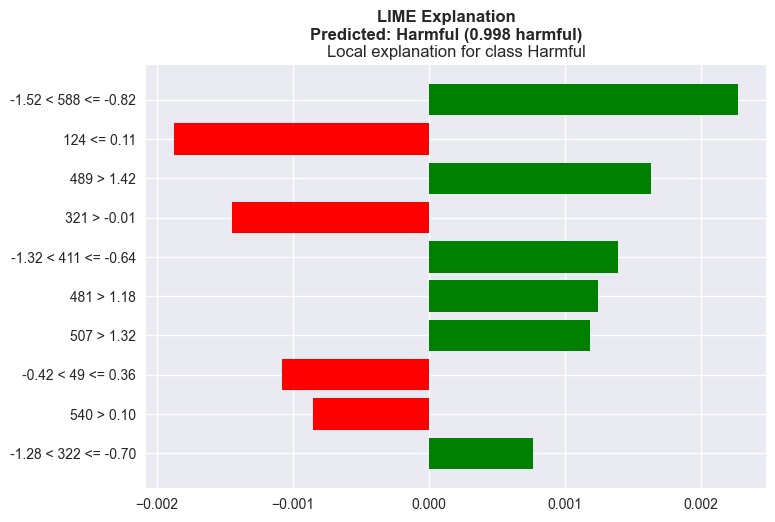


Sample 2: Thank you for your helpful feedback, very appreciated


Encoding texts: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


Prediction: Safe
Harmful probability: 0.0600
Safe probability: 0.9400


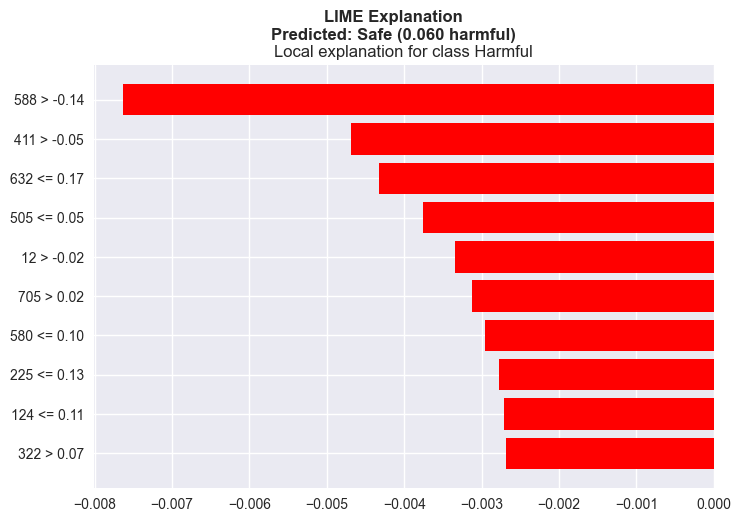


Sample 3: You're so stupid and should disappear forever


Encoding texts: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


Prediction: Harmful
Harmful probability: 0.9878
Safe probability: 0.0122


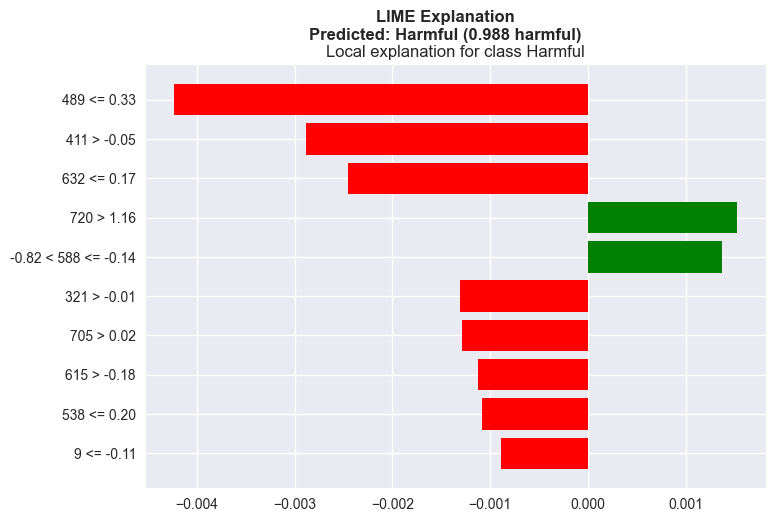


Sample 4: Have a wonderful day everyone, best wishes!


Encoding texts: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


Prediction: Safe
Harmful probability: 0.3015
Safe probability: 0.6985


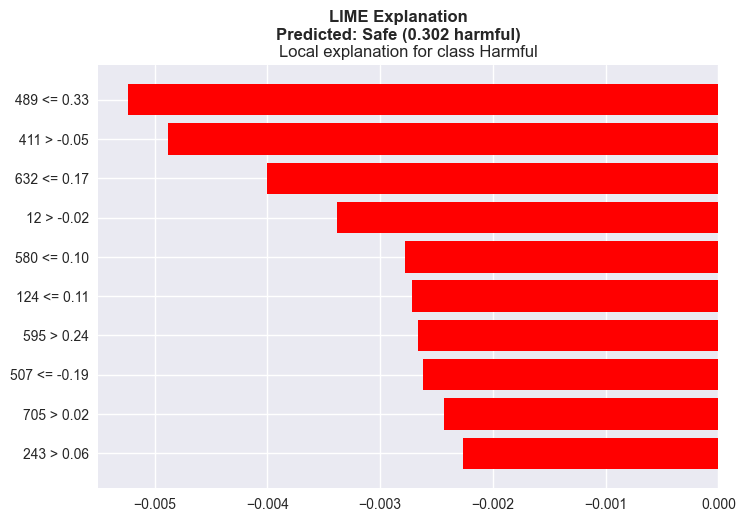

In [13]:
# Test predictions with explanations
test_samples = [
    "I hate all people from that country, they are worthless",
    "Thank you for your helpful feedback, very appreciated",
    "You're so stupid and should disappear forever",
    "Have a wonderful day everyone, best wishes!"
]

print("SAMPLE PREDICTIONS WITH EXPLANATIONS")

print("\n[LIME EXPLANATIONS]")
print("-" * 40)

for i, sample in enumerate(test_samples):
    print(f"\nSample {i+1}: {sample}")
    
    try:
        lime_result = xai_explainer.explain_with_lime(sample, num_features=10)
        
        print(f"Prediction: {lime_result['predicted_class']}")
        print(f"Harmful probability: {lime_result['harmful_probability']:.4f}")
        print(f"Safe probability: {lime_result['safe_probability']:.4f}")
        xai_explainer.plot_lime_explanation(
            lime_result, 
            save_path=f"{OUTPUT_DIR}/lime_explanation_sample_{i+1}.png"
        )
        
    except Exception as e:
        print(f"Error in LIME explanation: {e}")


[SHAP EXPLANATIONS]


Encoding texts: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


Computing SHAP values...

SHAP analysis completed!


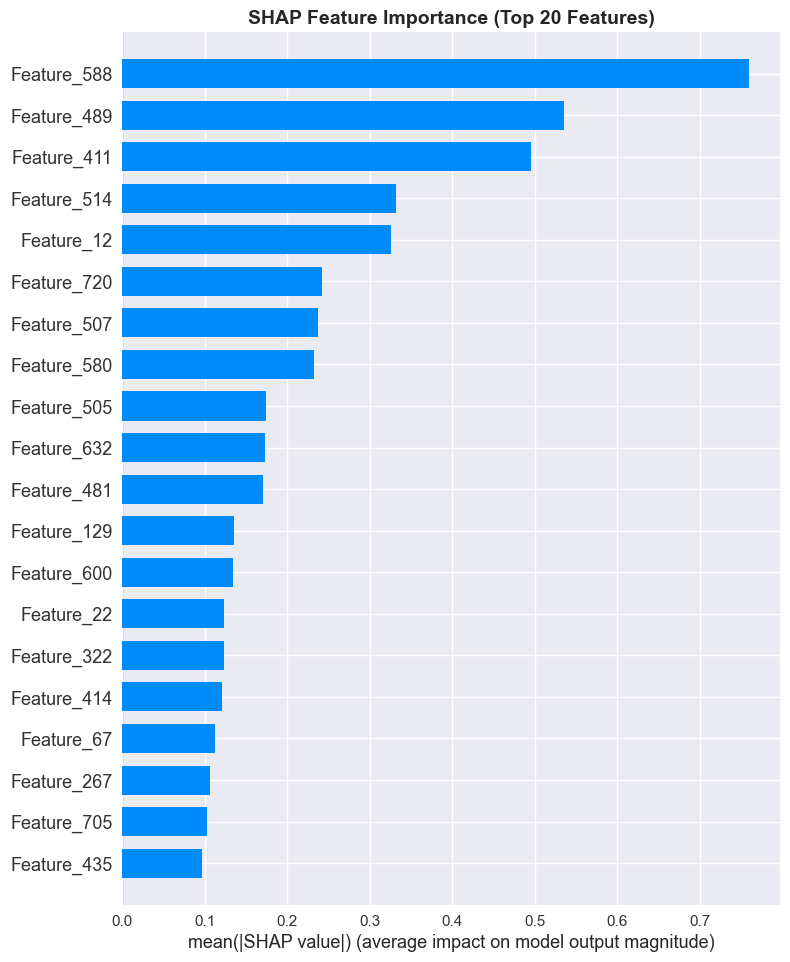


SHAP waterfall plot for first harmful sample:


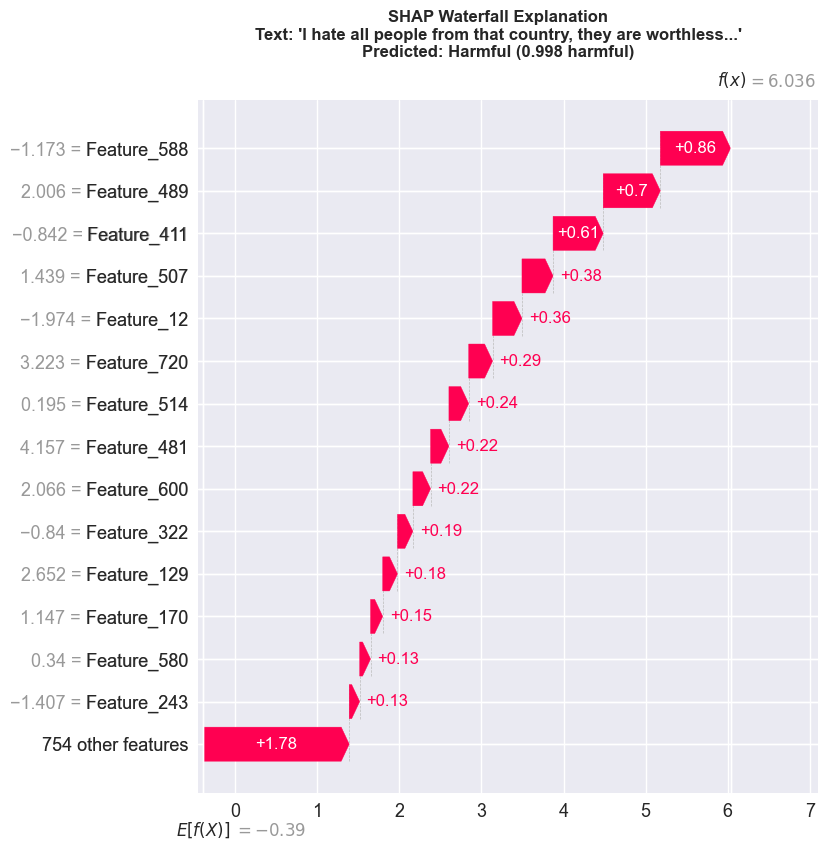


SHAP waterfall plot for first safe sample:


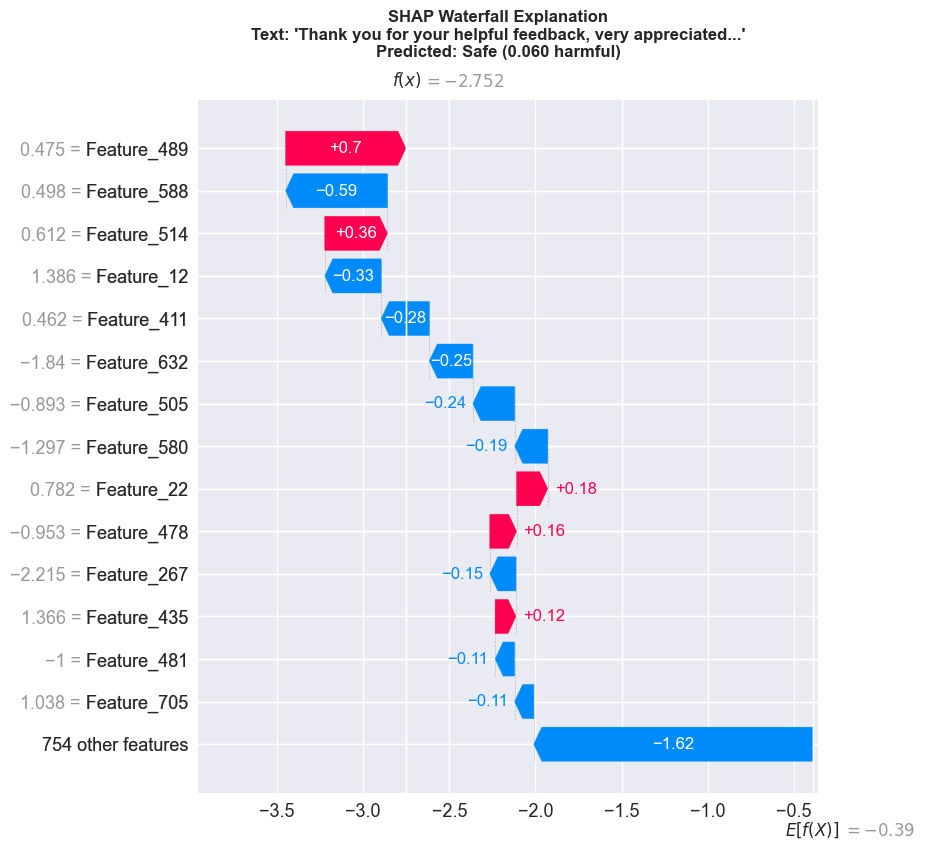

In [14]:
print("\n[SHAP EXPLANATIONS]")
try:
    # Use test samples for SHAP analysis
    shap_result = xai_explainer.explain_with_shap(test_samples)
    
    print("\nSHAP analysis completed!")
    
    # Plot SHAP summary
    xai_explainer.plot_shap_summary(
        shap_result, 
        save_path=f"{OUTPUT_DIR}/shap_summary.png"
    )
    
    # Plot SHAP waterfall for first sample
    print("\nSHAP waterfall plot for first harmful sample:")
    xai_explainer.plot_shap_waterfall(
        shap_result, 
        text_index=0, 
        save_path=f"{OUTPUT_DIR}/shap_waterfall_sample1.png"
    )
    
    # Plot SHAP waterfall for a safe sample
    print("\nSHAP waterfall plot for first safe sample:")
    xai_explainer.plot_shap_waterfall(
        shap_result, 
        text_index=1, 
        save_path=f"{OUTPUT_DIR}/shap_waterfall_sample2.png"
    )
    
except Exception as e:
    print(f"Error in SHAP explanation: {e}")
    import traceback
    traceback.print_exc()

In [15]:
# Final testing with enhanced predictions
print("\n" + "=" * 80)
print("FINAL ENHANCED PREDICTIONS WITH XAI")
print("=" * 80)

final_test_samples = [
    "I absolutely hate everyone from that group",
    "Thank you for the wonderful presentation today",
    "You are such an idiot and waste of space",
    "I hope you have a great day ahead",
    "This movie sucks but I respect others' opinions"
]

for i, sample in enumerate(final_test_samples):
    print(f"\n[Sample {i+1}]")
    print(f"Text: {sample}")
    
    # Make predictions
    embedding = encoder.encode_texts([sample])
    embedding_scaled = scaler.transform(embedding)
    
    prediction = final_model.predict(embedding_scaled)[0]
    probability = final_model.predict_proba(embedding_scaled)[0]
    
    pred_class = "HARMFUL" if prediction == 1 else "SAFE"
    confidence = "HIGH" if max(probability) > 0.9 else "MEDIUM" if max(probability) > 0.7 else "LOW"
    
    print(f"Prediction: {pred_class} (Confidence: {confidence})")
    print(f"Probabilities: Harmful={probability[1]:.4f}, Safe={probability[0]:.4f}")
    print("-" * 40)


FINAL ENHANCED PREDICTIONS WITH XAI

[Sample 1]
Text: I absolutely hate everyone from that group


Encoding texts: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


Prediction: HARMFUL (Confidence: HIGH)
Probabilities: Harmful=0.9939, Safe=0.0061
----------------------------------------

[Sample 2]
Text: Thank you for the wonderful presentation today


Encoding texts: 100%|██████████| 1/1 [00:00<00:00, 53.86it/s]


Prediction: SAFE (Confidence: HIGH)
Probabilities: Harmful=0.0185, Safe=0.9815
----------------------------------------

[Sample 3]
Text: You are such an idiot and waste of space


Encoding texts: 100%|██████████| 1/1 [00:00<00:00, 48.73it/s]


Prediction: HARMFUL (Confidence: HIGH)
Probabilities: Harmful=0.9869, Safe=0.0131
----------------------------------------

[Sample 4]
Text: I hope you have a great day ahead


Encoding texts: 100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


Prediction: SAFE (Confidence: HIGH)
Probabilities: Harmful=0.0055, Safe=0.9945
----------------------------------------

[Sample 5]
Text: This movie sucks but I respect others' opinions


Encoding texts: 100%|██████████| 1/1 [00:00<00:00, 51.71it/s]

Prediction: HARMFUL (Confidence: HIGH)
Probabilities: Harmful=0.9550, Safe=0.0450
----------------------------------------
